In [4]:
import pandas as pd
import numpy as np
import openpyxl
import re
from re import sub
from decimal import Decimal
import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from numpy import unique, where
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from IPython.display import display, HTML, display_html
import pickle

import os

In [5]:
from google.colab import drive 
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Capstone/Scripts/Amenities_part/')

Mounted at /content/drive


In [6]:
random_state = 0

In [7]:

airbnb_ny_listing  = r'../../Data/LA_Airbnb/listings_detailed.csv'

In [ ]:
# Data Cleaning
df_listing = pd.read_csv(airbnb_ny_listing)
df_listing['neighbourhood_cleansed'] = df_listing['neighbourhood_cleansed'].apply(lambda x: str(x).lower())
df_listing['amenities'] = df_listing['amenities'].apply(lambda x: str(x).lower())
df_listing['property_type'] = df_listing['property_type'].apply(lambda x: str(x).lower())
df_listing['room_type'] = df_listing['room_type'].apply(lambda x: str(x).lower())
df_listing['bathrooms_text'] = df_listing['bathrooms_text'].fillna(0)
df_listing['bathrooms_text'] = df_listing['bathrooms_text'].apply(lambda x: str(x).lower())
df_listing['bedrooms'] = df_listing['bedrooms'].fillna(0)
df_listing['beds'] = df_listing['beds'].fillna(0)
df_listing['price'] = df_listing['price'].apply(lambda x: float(Decimal(sub(r'[^\d.]', '', x))))
df_listing['latitude'] = np.round(df_listing['latitude'],5)
df_listing['longitude'] = np.round(df_listing['longitude'],5)

len(df_listing)

40438

In [ ]:
df_listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [ ]:
df_listing.head(2)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,65467,https://www.airbnb.com/rooms/65467,20221206172243,2022-12-07,city scrape,A Luxury Home in Los Angeles,<b>The space</b><br />Private 16 x 15 ft room ...,NaN,https://a0.muscache.com/pictures/821696/64d8a6...,61864,...,NaN,NaN,NaN,NaN,f,2,0,2,0,NaN
1,206662,https://www.airbnb.com/rooms/206662,20221206172243,2022-12-07,city scrape,"Hollywood & Hiking, 30 day minimum","Semi-Private, vaccinated only, you will be sta...",The quietest part of Hollywood yet still walka...,https://a0.muscache.com/pictures/30274679/5011...,33861,...,4.92,4.92,4.87,NaN,f,1,0,1,0,0.71


In [ ]:
property_features = ['id', 'latitude','longitude', 'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities','minimum_nights', 'maximum_nights', 'price'] 
# Need to read documentation for meaning
# , 'minimum_minimum_nights','maximum_minimum_nights', 'minimum_maximum_nights',
# 'maximum_maximum_nights', 'minimum_nights_avg_ntm','maximum_nights_avg_ntm']

In [ ]:
df_listing[property_features].head(2)

,id,latitude,longitude,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,price
0,65467,34.02438,-118.38374,culver city,private room in home,private room,2,NaN,2 baths,1.0,1.0,"[""wifi"", ""tv with standard cable"", ""long term ...",60,730,300.0
1,206662,34.10420,-118.34748,hollywood hills west,private room in condo,private room,1,NaN,1 shared bath,1.0,2.0,"[""tv with standard cable"", ""hot water"", ""first...",30,30,46.0


In [ ]:
# Source for list of amenities
# https://towardsdatascience.com/predicting-airbnb-prices-with-deep-learning-part-1-how-to-clean-up-airbnb-data-a5d58e299f6c
# Airbnb standard amenities list extracted from host account
# compund a list of amenities based on both sources above 
# Realised amenities made up of generic and customised items for usually brands after going through the amenities section
# of the data set, making it hard to build a generalisable features for each listings

#####################
# NOTE: To be convert into a text file for ease of extraction
#####################
raw_amenities_list = ["24-hour check-in",'Accessible-height bed','Accessible-height toilet','Air conditioning','Air purifier',
 'Alfresco bathtub','Amazon Echo','Apple TV','BBQ grill','Baby bath','Baby monitor','Babysitter recommendations',
 'Balcony','Bath towel','Bathroom essentials','Bathtub','Bathtub with bath chair','Beach essentials',
 'Beach view','Beachfront','Bed linens','Bedroom comforts','Bidet','Body soap','Breakfast','Breakfast bar','Breakfast table',
 'Building staff','Buzzer/wireless intercom','Cable TV','Carbon monoxide detector','Cat','Ceiling fan','Ceiling hoist',
 'Central air conditioning','Changing table',"Chef's kitchen",'Children’s books and toys','Children’s dinnerware',
 'Cleaning before checkout','Coffee maker','Convection oven','Cooking basics','Crib','DVD player','Day bed',
 'Dining area','Disabled parking spot','Dishes and silverware','Dishwasher','Dog','Doorman','Double oven','Dryer',
 'EV charger','Electric profiling bed','Elevator','En suite bathroom','Espresso machine','Essentials','Ethernet connection',
 'Exercise equipment','Extra pillows and blankets','Family/kid friendly','Fax machine','Fire extinguisher','Fire pit',
 'Fireplace guards','Firm mattress','First aid kit','Fixed grab bars for shower','Fixed grab bars for toilet',
 'Flat path to front door','Formal dining area','Free parking on premises','Free street parking','Full kitchen','Game console',
 'Garden or backyard','Gas oven','Ground floor access','Gym','HBO GO','Hair dryer','Hammock','Handheld shower head',
 'Hangers','Heat lamps','Heated floors','Heated towel rack','Heating','High chair','High-resolution computer monitor',
 'Host greets you','Hot tub','Hot water','Hot water kettle','Indoor fireplace','Internet','Iron','Ironing Board',
 'Jetted tub','Keypad','Kitchen','Kitchenette','Lake access','Laptop friendly workspace','Lock on bedroom door',
 'Lockbox','Long term stays allowed','Luggage dropoff allowed','Memory foam mattress','Microwave','Mini fridge',
 'Mobile hoist','Mountain view','Mudroom','Murphy bed','Netflix','Office','Other','Other pet(s)','Outdoor kitchen',
 'Outdoor parking','Outdoor seating','Outlet covers','Oven','Pack ’n Play/travel crib','Paid parking off premises',
 'Paid parking on premises','Patio or balcony','Pets allowed','Pets live on this property','Pillow-top mattress',
 'Pocket wifi','Pool','Pool cover','Pool with pool hoist','Printer','Private bathroom','Private entrance',
 'Private gym','Private hot tub','Private living room','Private pool','Projector and screen','Propane barbeque','Rain shower',
 'Refrigerator','Roll-in shower','Room-darkening shades','Safe','Safety card','Sauna','Security system','Self check-in',
 'Shampoo','Shared gym','Shared hot tub','Shared pool','Shower chair','Single level home','Ski-in/Ski-out','Smart TV',
 'Smart lock','Smoke detector','Smoking allowed','Soaking tub','Sound system','Stair gates','Stand alone steam shower',
 'Standing valet','Steam oven','Step-free access','Stove','Suitable for events','Sun loungers','TV','Table corner guards',
 'Tennis court','Terrace','Toilet paper','Touchless faucets','Walk-in shower','Warming drawer','Washer','Washer / Dryer',
 'Waterfront','Well-lit path to entrance','Wheelchair accessible','Wide clearance to bed','Wide clearance to shower',
 'Wide doorway','Wide entryway','Wide hallway clearance','Wifi','Window guards','Wine cooler','toilet','Bath',
 'Bidet','Body soap','Cleaning products','Conditioner','Hair dryer','Hot water','Outdoor shower','Shampoo','Shower gel',
 'Essentials','Bed linen','Clothes storage','Dryer','Clothes drying rack','Extra pillows and blankets','Hangers','Iron',
 'Mosquito net','Room-darkening shades','Safe','Washing machine','Arcade games','Batting cage','Books and reading material',
 'Bowling alley','Climbing wall','Ethernet connection','Exercise equipment','Games console','Laser tag','Life-size games',
 'Mini golf','Cinema','Piano','Ping pong table','Pool table','Record player','Skate ramp','Sound system','Theme room',
 'TV','Baby bath','Baby monitor','Children’s bikes','Children’s playroom','Baby safety gates','Babysitter recommendations',
 'Board games','Changing table','Children’s books and toys','Children’s tableware','Cot','Fireplace guards','High chair',
 'Outdoor playground','Plug socket covers','Travel cot','Table corner guards','Window guards', 'Air conditioning',
 'Ceiling fan','Heating','Indoor fireplace','Portable fans','Carbon monoxide alarm','Fire extinguisher', 'First aid kit',
 'Smoke alarm','Dedicated workspace','Pocket wifi','Wifi','Baking sheet','Barbecue utensils','Bread maker','Blender',
 'Coffee','Coffee maker','Cooking basics','Dining table','Dishes and silverware','Dishwasher','Freezer','Kettle','Kitchen',
 'Kitchenette','Microwave','Mini fridge','Oven','Refrigerator','Rice cooker','Stove','Toaster','Waste compactor','Wine glasses',
 'Beach access','Lake access','Launderette nearby','Private entrance','Resort access','Ski-in/Ski-out','Waterfront',
 'Garden','BBQ grill','Beach essentials','Bikes','Boat berth','Fire pit','Hammock','Kayak','Outdoor dining area',
 'Outdoor furniture','Outdoor kitchen','Patio or balcony','Sun loungers','Lift','EV charger','Free parking on premises',
 'Hockey rink','Free on-street parking','Gym','Hot tub','Paid parking off premises','Paid parking on premises','Pool','Sauna',
 'Single level home','Breakfast','Cleaning available during stay','Long-term stays allowed','Luggage drop-off allowed']

len(raw_amenities_list)

330

In [ ]:
# Get the unique amenities available in Airbnb
raw_amenities_list = [i.lower() for i in raw_amenities_list]
amenities_universe = np.unique(raw_amenities_list)

In [ ]:
# Use regex to convert the string of amenities into individual string object to check if the object is in the amenities universe
pattern = r'\"(.*?)\"'
# This step ignores the idea that there might be more than 1 amenities
df_listing['amenities_clean'] = df_listing['amenities'].apply(lambda x: [i for i in re.findall(pattern,x) if i in amenities_universe])
# Convert list of amenities for each property for subsequent use of Vectoriser
df_listing['amenities_clean_vec'] = df_listing['amenities_clean'].apply(lambda x: '"'.join(x))
# Count the number of amenities listed for the property
df_listing['amenities_count'] = df_listing['amenities_clean'].apply(lambda x: len(x))

In [ ]:
# Count vectorizer - This step will naturally collate the full list of amenities based on the detail dataset
#                    which is a subset of the amenities_universe
# Use regex to tokenize the string for count vectorizer
pattern = r'\"(.*?)\"'
vectorizer_count = CountVectorizer(token_pattern = pattern)
property_amenities_list = [i for i in df_listing['amenities_clean_vec']]

property_features_count_vectorized = vectorizer_count.fit_transform(property_amenities_list)
amenities_feature_count_name_clean = vectorizer_count.get_feature_names_out()
amenities_feature_count_data_clean = property_features_count_vectorized.toarray()
amenities_feature_count_df = pd.DataFrame(amenities_feature_count_data_clean,columns = amenities_feature_count_name_clean)
amenities_feature_count_df.head()

,air conditioning,apple tv,baby bath,baby monitor,baby safety gates,babysitter recommendations,baking sheet,balcony,barbecue utensils,bathroom essentials,...,tennis court,terrace,toaster,tv,washer,waterfront,wifi,window guards,wine cooler,wine glasses
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Bathroom
# 3 new columns:
#   - bathroom_count
#   - bathroom_type: Assumed to be "private" if "shared" is not mentioned 
#   - bathrooms_type_code: shared=0 & private=1
float_pattern = r"[-+]?(?:\d*\.*\d+)"

df_listing['bathrooms_count'] = df_listing['bathrooms_text'].apply(lambda x: re.findall(float_pattern,str(x)) if x != 'half' else [0.5])
df_listing['bathrooms_count'] = df_listing['bathrooms_count'].apply(lambda x: x[0] if len(x)>0 else 0)
df_listing['bathrooms_type'] = df_listing['bathrooms_text'].apply(lambda x: 'shared' if 'shared' in str(x) else 'private')
df_listing['bathrooms_type_code'] = np.where(df_listing['bathrooms_type']=='shared',0,1)

In [ ]:
# Property and room type
# 3 new columns:
#   - property_type_clean: Remove qualitative words in the "prohibitedwords" list to identify unique property type
#   - property_type_code: Assign a number to each property type
#   - room_type_code: Assign a number to each room type (This offers qualitative description for the property type i.e. "private","shared")
prohibitedWords = ['private', 'shared', ' in ', 'entire', 'room'] # added spaces in front and behind 'in' to ensure accuracy
big_regex = re.compile('|'.join(map(re.escape, prohibitedWords)))
df_listing['property_type_clean'] =  df_listing['property_type'].apply(lambda x: big_regex.sub("", x).strip())
df_listing['property_type_clean'] = np.where(df_listing['property_type_clean']=='',df_listing['room_type'],df_listing['property_type_clean'])

# create dictionary for property type code
property_type_list = list(np.unique(df_listing['property_type_clean']))
property_type_dict = dict(zip(property_type_list,np.arange(len(property_type_list))))

# create dictionary for room type code
room_type_list = list(np.unique(df_listing['room_type']))
room_type_dict = dict(zip(room_type_list,np.arange(len(room_type_list))))

# Assign property type code
df_listing['property_type_code'] = df_listing['property_type_clean'].apply(lambda x: property_type_dict[x])

# Assign room type code
df_listing['room_type_code'] = df_listing['room_type'].apply(lambda x: room_type_dict[x])

In [ ]:
# neighbourhood_cleansed
# 1 new column:
#    - neighbourhood_cleansed_code: index the neighbourhood_cleansed column to further segregate the property according to the location

neighbourhood_cleansed_dict = dict(zip(np.unique(df_listing['neighbourhood_cleansed']),np.arange(len(np.unique(df_listing['neighbourhood_cleansed'])))))
df_listing['neighbourhood_cleansed_code'] = df_listing['neighbourhood_cleansed'].apply(lambda x: neighbourhood_cleansed_dict[x])

In [ ]:
# Recontruct the final dataframe for analysis
required_column_list = ['price','latitude','longitude','property_type_code','room_type_code', 'neighbourhood_cleansed_code',
                        'bedrooms', 'beds','bathrooms_type_code','bathrooms_count','minimum_nights', 'maximum_nights',
                        'amenities_count',]

final_df = df_listing[required_column_list].join(amenities_feature_count_df)
print("Number of features {}".format(len(final_df.columns)-1))
display(final_df.head())
# final_df.dtypes

Number of features 169


,price,latitude,longitude,property_type_code,room_type_code,neighbourhood_cleansed_code,bedrooms,beds,bathrooms_type_code,bathrooms_count,...,tennis court,terrace,toaster,tv,washer,waterfront,wifi,window guards,wine cooler,wine glasses
0,300.0,34.02438,-118.38374,22,2,52,1.0,1.0,1,2,...,0,0,0,0,0,0,0,0,0,0
1,46.0,34.10420,-118.34748,14,2,104,1.0,2.0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,140.0,34.00985,-118.40798,21,0,52,1.0,1.0,1,1,...,0,0,0,1,0,0,0,0,0,0
3,340.0,34.05303,-118.39449,42,0,169,3.0,5.0,1,3,...,0,0,0,0,1,0,0,0,0,0
4,115.0,33.98301,-118.38607,14,0,52,2.0,3.0,1,2,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
#### save
final_df.to_csv('amenities.csv',index=False)


In [8]:
final_df = pd.read_csv('amenities.csv')

# KMeans Clustering

In [9]:
distortions = []
inertias = []
mapping = {}

from sklearn.preprocessing import StandardScaler
K = range(1, 10)
model_data_raw = final_df.copy()
for k in K:
    dateset = StandardScaler().fit_transform(model_data_raw.iloc[:,1:])
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, random_state=random_state)
    kmeanModel.fit(dateset)
    inertias.append(kmeanModel.inertia_)
    mapping[k] = kmeanModel.inertia_ 

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

1 : 6834022.000000015
2 : 6624692.774075694
3 : 6531765.108034417
4 : 6442242.716780586
5 : 6339437.849415813
6 : 6269420.842752123
7 : 6206398.674039077
8 : 6137986.326819213
9 : 6087449.131314386


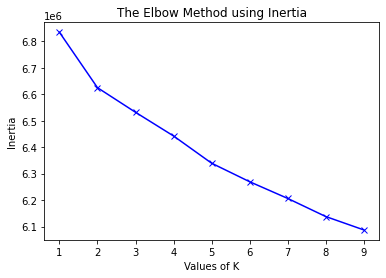

In [10]:
for key, val in mapping.items():
    print(f'{key} : {val}')
    
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()    

In [17]:
model_data_raw = final_df.copy()
clusters = 2
# define the model
kmeans_model = KMeans(n_clusters=clusters, random_state=random_state)

# train the model
kmeans_model.fit(model_data_raw.iloc[:,1:])


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=0)

(array([15940., 24498.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

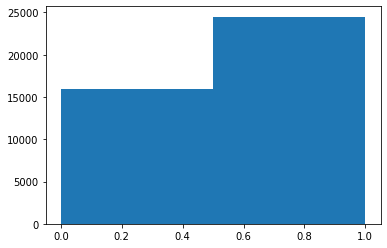

In [18]:
model_data_raw['cluster'] = kmeans_model.labels_
plt.hist(kmeans_model.labels_, bins=clusters)

# Minimum data for each cluster to be considered is 20% of total data
# Minimum 3 clusters
# Total cluster data point 90% of the data set

In [13]:
# Requirements for a valid cluster for predict
#   - Have sufficient data points
#   - Cluster with insufficient data points will not be considered
#   - Host can set price need to do a cost-plus approach and closest competitor as reference
proportion_of_data = 1/clusters
valid_cluster_list = [ i for i in np.arange(clusters) 
                 if len(model_data_raw[model_data_raw['cluster']==i])/len(model_data_raw)>=proportion_of_data]
valid_cluster_list

[1]

In [14]:
valid_cluster_list = [0,1]

# Random Forest Regressor (RFR)

### RFR: Initial Exploration

Model parameters for cluster 0
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
Elapsed time to compute the importances: 32.624 seconds for cluster 0


Prediction vs Test set for cluster 0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
predict,151.0,156.0,96.0,195.0,432.0,332.0,118.0,320.0,131.0,105.0,6567.0,93.0,103.0,292.0,1120.0,169.0,360.0,115.0,391.0,446.0
test,90.0,132.0,40.0,158.0,775.0,195.0,60.0,239.0,120.0,95.0,9999.0,90.0,39.0,175.0,350.0,169.0,300.0,59.0,500.0,266.0


Score for test set: 0.581163232526414
Score for train set: 0.9225421797206116




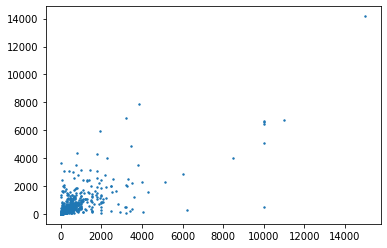

Model parameters for cluster 1
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
Elapsed time to compute the importances: 53.234 seconds for cluster 1


Prediction vs Test set for cluster 1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
predict,136.0,1732.0,197.0,377.0,150.0,170.0,35.0,170.0,80.0,281.0,810.0,189.0,345.0,118.0,1402.0,156.0,181.0,181.0,178.0,231.0
test,136.0,285.0,213.0,159.0,130.0,142.0,35.0,148.0,64.0,300.0,347.0,211.0,315.0,100.0,2980.0,125.0,171.0,180.0,212.0,107.0


Score for test set: -0.3939513369805483
Score for train set: 0.8571251986343947




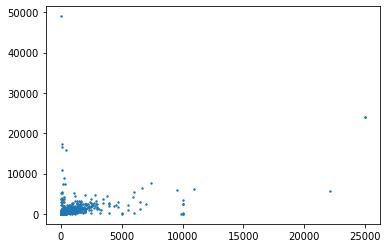

In [16]:
# This list will take reference to the valid cluster list in terms of the sequence of the model
rfr_cluster_model_list = []

for cluster in valid_cluster_list:
    start_time = time.time()
    cluster_number = cluster
    # Select data belonging to selected cluster
    model_data = model_data_raw.copy()[model_data_raw['cluster']==cluster_number]
    # define X and Y data
    y = model_data['price'].to_numpy()
    X = model_data.iloc[:,1:].to_numpy()
    # train test split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=random_state)
    
    # Training model for using Random Forest Regressor
#     feature_names = [f"feature {i}" for i in range(X.shape[1])]
    forest = RandomForestRegressor(random_state=random_state)
    forest.fit(X_train, y_train)
    rfr_cluster_model_list.append(forest)
    print(f"Model parameters for cluster {cluster_number}")
    print(forest.get_params())
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds for cluster {cluster_number}")
    print('\n')
    
    # Evaluation of the model performance
    rfr_y_predict = np.round(forest.predict(X_test),0)
    # Extract a sample for prediction and test for scoring and visual comparison 
    sample_size = 20
    forest_sample_comparison_df = pd.DataFrame({'predict':rfr_y_predict[:sample_size],'test':list(y_test[:sample_size])}).T
    print(f"Prediction vs Test set for cluster {cluster_number}")
    display(forest_sample_comparison_df)
    print('Score for test set: {}'.format(forest.score(X_test,y_test)))
    print('Score for train set: {}'.format(forest.score(X_train,y_train)))
    print('\n')
    plt.scatter(y_test,forest.predict(X_test),s=2)
    plt.show()

### RFR: Grid Search and Cross Validation

In [ ]:
# Create the parameter grid based on the results of random search 
rfr_param_grid = {
    'max_depth': [None, ],#60, 80, 100],
    'min_samples_leaf': [1, 2],#, 3, 4],
    'min_samples_split': [2, 4],#, 6, 8],
    'n_estimators': [100],#, 500, 1000]
}

In [ ]:
rfr_best_params_cluster_list = []

for i in range(len(valid_cluster_list)):
    # Extract the data for each cluster
    cluster_number = valid_cluster_list[i]
    # Select data belonging to selected cluster
    model_data = model_data_raw.copy()[model_data_raw['cluster']==cluster_number]
    # define X and Y data
    y = model_data['price'].to_numpy()
    X = model_data.iloc[:,1:].to_numpy()
    # train test split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=random_state)
    
    start_time = time.time()
    # Create a based model
    rf = RandomForestRegressor(random_state=random_state)
    # Instantiate and fitting the grid search model
    print(f'Cluster {cluster_number}: Grid search and cross validation')
    grid_search = GridSearchCV(estimator = rf, param_grid = rfr_param_grid, 
                              cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X_train, y_train)

    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
    
    rfr_best_params = grid_search.best_params_
    rfr_best_params_cluster_list.append(rfr_best_params)
    print(f'Cluster {cluster_number}: Best Paramters')
    print(rfr_best_params)

Cluster 0: Grid search and cross validation
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Elapsed time to compute the importances: 103.035 seconds
Cluster 0: Best Paramters
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Cluster 2: Grid search and cross validation
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Elapsed time to compute the importances: 163.601 seconds
Cluster 2: Best Paramters
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


### RFR: Model based on best parameters

In [ ]:
rfr_cluster_best_model_list = []

for i in range(len(valid_cluster_list)):
    # Extract the data for each cluster
    cluster_number = valid_cluster_list[i]
    # Select data belonging to selected cluster
    model_data = model_data_raw.copy()[model_data_raw['cluster']==cluster_number]
    # define X and Y data
    y = model_data['price'].to_numpy()
    X = model_data.iloc[:,1:].to_numpy()
    # train test split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=random_state)


    start_time = time.time()

    forest_best = RandomForestRegressor(n_estimators = rfr_best_params['n_estimators'],
                                   max_depth = rfr_best_params['max_depth'],
                                   min_samples_leaf = rfr_best_params['min_samples_leaf'],
                                   min_samples_split = rfr_best_params['min_samples_split'],
                                   random_state=random_state)
    forest_best.fit(X_train, y_train)
#     importances_forest = forest_best.feature_importances_
    # Dump the model into a pickle file
    rfr_pickle_path = r"D:\IMPT Drive\Uni Michigan Applied DS\SIADS_699_Capstone\LA_data\airbnb_randomforestregressor_"+str(cluster_number)+".pkl"
    pickle.dump(forest_best, open(rfr_pickle_path, "wb"))
    forest_best = pickle.load(open(rfr_pickle_path, "rb"))
    rfr_cluster_best_model_list.append(forest_best)
    
    # Evaluation of the model performance
    rfr_y_predict = np.round(forest_best.predict(X_test),0)
    forest_sample_comparison_df = pd.DataFrame({'predict':rfr_y_predict[:20],'test':list(y_test[:20])}).T
    display(forest_sample_comparison_df)
    print('Score for test set: {}'.format(forest_best.score(X_test,y_test)))
    print('Score for train set: {}'.format(forest_best.score(X_train,y_train)))
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to best model evaluation: {elapsed_time:.3f} seconds")
    print('\n')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
predict,757.0,210.0,84.0,167.0,116.0,982.0,172.0,73.0,209.0,278.0,320.0,205.0,240.0,245.0,111.0,97.0,119.0,142.0,236.0,182.0
test,924.0,281.0,125.0,114.0,200.0,1450.0,74.0,69.0,173.0,69.0,384.0,179.0,225.0,192.0,110.0,100.0,77.0,87.0,168.0,180.0


Score for test set: 0.6557934260554857
Score for train set: 0.9069339008964259
Elapsed time to best model evaluation: 25.886 seconds




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
predict,938.0,137.0,78.0,137.0,326.0,153.0,169.0,399.0,84.0,96.0,164.0,212.0,498.0,225.0,49.0,82.0,72.0,403.0,160.0,224.0
test,1039.0,79.0,50.0,110.0,550.0,123.0,139.0,490.0,100.0,89.0,166.0,163.0,464.0,388.0,50.0,75.0,75.0,363.0,204.0,107.0


Score for test set: 0.6716423828879767
Score for train set: 0.9182203562358338
Elapsed time to best model evaluation: 48.341 seconds




### RFR: Feature Importances (highlight to host about the critical features)

Cluster 0: Chart for feature importances


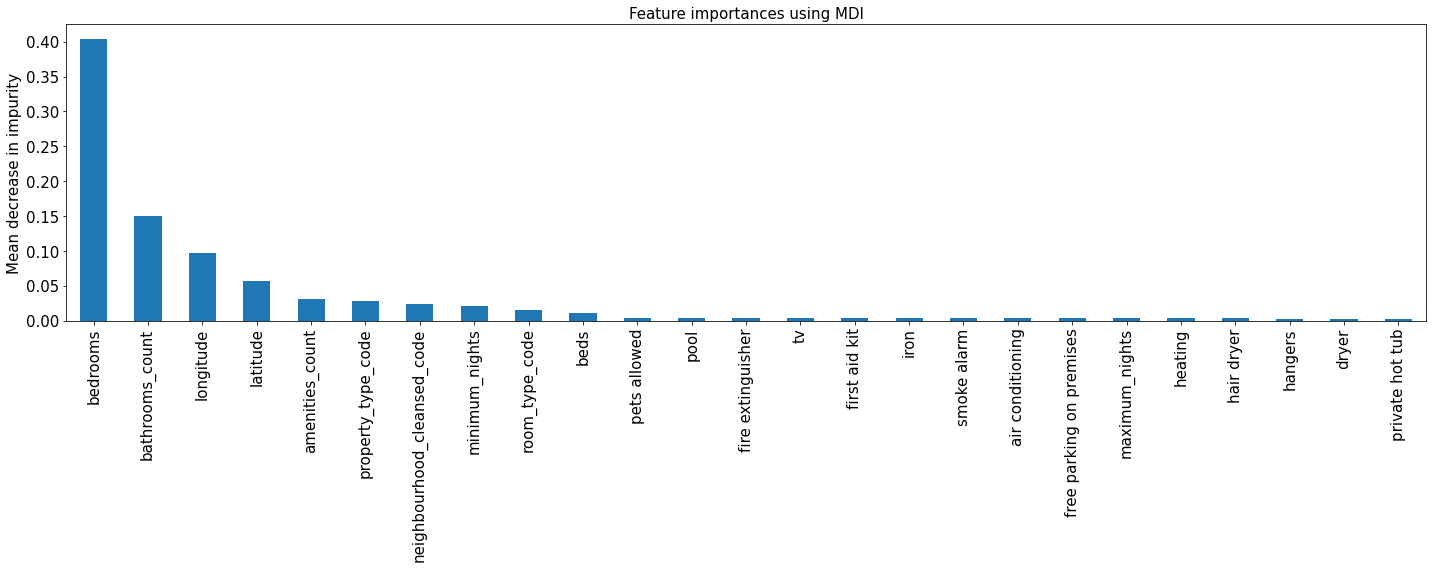



Cluster 2: Chart for feature importances


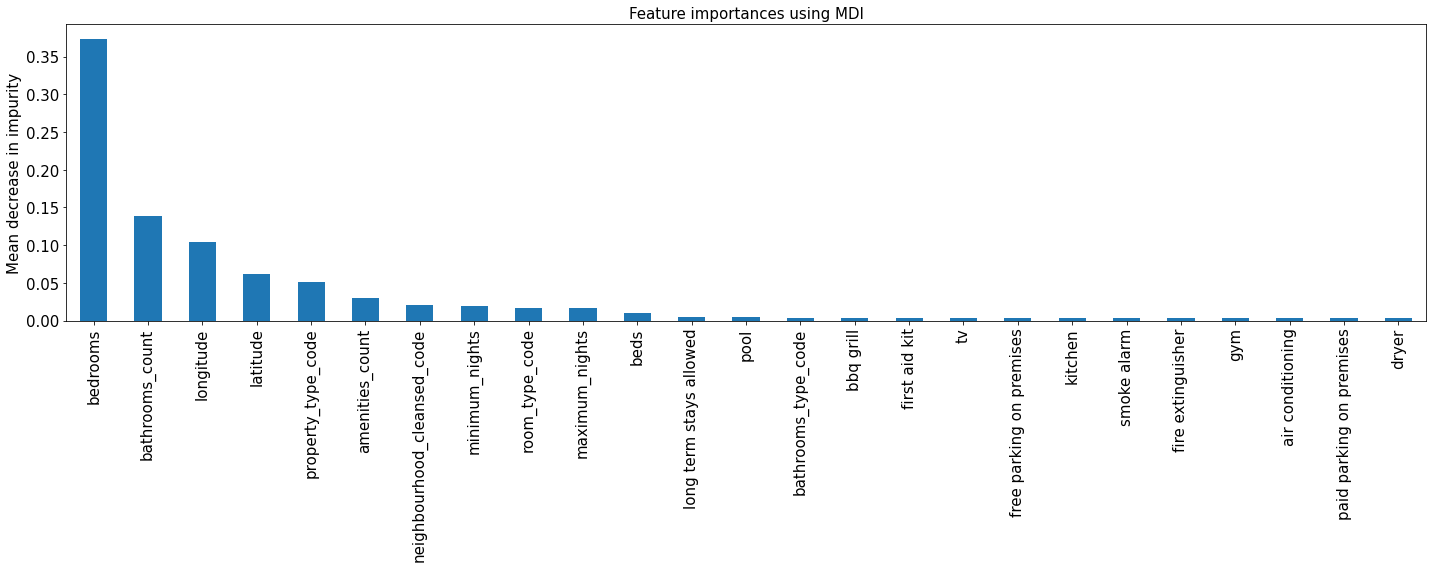

In [ ]:
importance_count = 25

rfr_cluster_top_feature_importance = []

for i in range(len(valid_cluster_list)):
    # Extract the data for each cluster
    cluster_number = valid_cluster_list[i]
    best_model = rfr_cluster_best_model_list[i]
    importances_forest = best_model.feature_importances_
    
    forest_importances = pd.Series(importances_forest, index=model_data.columns[1:])
    forest_importances_top = forest_importances.sort_values(ascending=False).iloc[:importance_count]
    rfr_cluster_top_feature_importance.append(forest_importances_top)
    print(f'Cluster {cluster_number}: Chart for feature importances')
    
    fig, ax = plt.subplots(figsize=(20,8))
    forest_importances_top.plot.bar(forest_importances_top, ax=ax)
    ax.set_title("Feature importances using MDI",fontsize=15)
    ax.set_ylabel("Mean decrease in impurity",fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    fig.tight_layout()
    plt.show()
    print('\n')

# XGBoost Regressor (XGB)

### XGB: Initial Exploration

In [ ]:
# This list will take reference to the valid cluster list in terms of the sequence of the model
xgb_cluster_model_list = []

for cluster in valid_cluster_list:
    start_time = time.time()
    cluster_number = cluster
    # Select data belonging to selected cluster
    model_data = model_data_raw.copy()[model_data_raw['cluster']==cluster_number]
    # define X and Y data
    y = model_data['price'].to_numpy()
    X = model_data.iloc[:,1:].to_numpy()
    # train test split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=random_state)
    
    xgbregressor = XGBRegressor(random_state=random_state)
    xgbregressor.fit(X_train, y_train)
    xgb_cluster_model_list.append(xgbregressor)
    print(xgbregressor.get_xgb_params())
    # get importance
#     importance_xgbregressor = xgbregressor.feature_importances_
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
    
    # Evaluation of the model performance
    xgb_y_predict = np.round(xgbregressor.predict(X_test),0)
    xgboost_sample_comparison_df = pd.DataFrame({'predict':xgb_y_predict[:20],'test':list(y_test[:20])}).T
    display(xgboost_sample_comparison_df)
    # View accuracy score
    print('Score for test set: {}'.format(xgbregressor.score(X_test,y_test)))
    print('Score for train set: {}'.format(xgbregressor.score(X_train,y_train)))
    print('\n')

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Elapsed time to compute the importances: 5.414 seconds


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
predict,817.0,250.0,128.0,133.0,100.0,974.0,177.0,84.0,315.0,233.0,129.0,188.0,210.0,186.0,123.0,107.0,91.0,109.0,211.0,182.0
test,924.0,281.0,125.0,114.0,200.0,1450.0,74.0,69.0,173.0,69.0,384.0,179.0,225.0,192.0,110.0,100.0,77.0,87.0,168.0,180.0


Score for test set: 0.6843624756144725
Score for train set: 0.913260942148704


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Elapsed time to compute the importances: 6.779 seconds


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
predict,1118.0,134.0,49.0,112.0,435.0,189.0,93.0,372.0,100.0,85.0,129.0,195.0,465.0,179.0,34.0,70.0,63.0,400.0,142.0,190.0
test,1039.0,79.0,50.0,110.0,550.0,123.0,139.0,490.0,100.0,89.0,166.0,163.0,464.0,388.0,50.0,75.0,75.0,363.0,204.0,107.0


Score for test set: 0.6795870480599622
Score for train set: 0.8834642417695858




### XGB: Grid Search and Cross Validation

In [ ]:
# Create the parameter grid based on the results of random search 
xgb_param_grid = {'learning_rate': [0.3],#, 0.5, .07], #so called `eta` value
                            'max_depth': [5, 7],#, 10, 12],
                            'min_child_weight': [1, 3],#, 5, 7],
                            'subsample': [1]#, 0.5, 0.75, 1]
                }

In [ ]:
xgb_best_params_cluster_list = []

for i in range(len(valid_cluster_list)):
    # Extract the data for each cluster
    cluster_number = valid_cluster_list[i]
    # Select data belonging to selected cluster
    model_data = model_data_raw.copy()[model_data_raw['cluster']==cluster_number]
    # define X and Y data
    y = model_data['price'].to_numpy()
    X = model_data.iloc[:,1:].to_numpy()
    # train test split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=random_state)
    
    
    start_time = time.time()
    # Create a based model
    xgb = XGBRegressor(random_state=random_state)
    # Instantiate the grid search model
    xgb_grid_search = GridSearchCV(estimator = xgb, param_grid = xgb_param_grid, 
                              cv = 3, n_jobs = -1, verbose = 2)
    
    xgb_grid_search.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the best parameters: {elapsed_time:.3f} seconds")
    
    xbg_best_params = xgb_grid_search.best_params_
    xgb_best_params_cluster_list.append(xbg_best_params)
    print(f'Cluster {cluster_number}: Best Paramters')
    print(xbg_best_params)
    print('\n')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Elapsed time to compute the best parameters: 36.244 seconds
Cluster 0: Best Paramters
{'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1}


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Elapsed time to compute the best parameters: 51.148 seconds
Cluster 2: Best Paramters
{'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 1}




### XGB: Model based on best parameters

In [ ]:
xgb_cluster_best_model_list = []

for i in range(len(valid_cluster_list)):
    # Extract the data for each cluster
    cluster_number = valid_cluster_list[i]
    # Select data belonging to selected cluster
    model_data = model_data_raw.copy()[model_data_raw['cluster']==cluster_number]
    # define X and Y data
    y = model_data['price'].to_numpy()
    X = model_data.iloc[:,1:].to_numpy()
    # train test split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=random_state)


    start_time = time.time()

    xgbregressor_best = XGBRegressor(learning_rate = xbg_best_params['learning_rate'], #so called `eta` value
                                max_depth = xbg_best_params['max_depth'],
                                min_child_weight = xbg_best_params['min_child_weight'],
                                subsample = xbg_best_params['subsample'],
                                random_state=random_state)
    xgbregressor_best.fit(X_train, y_train)
    
    # Dump the model into a pickle file
    xgb_pickle_path = r"D:\IMPT Drive\Uni Michigan Applied DS\SIADS_699_Capstone\LA_data\airbnb_xgboost_"+str(cluster_number)+".pkl"
    pickle.dump(xgbregressor_best, open(xgb_pickle_path, "wb"))
    xgbregressor_best = pickle.load(open(xgb_pickle_path, "rb"))
    xgb_cluster_best_model_list.append(xgbregressor_best)

    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
    # Make predictions for the test training set
    # Comparison for the test set label
    xgb_y_predict = np.round(xgbregressor_best.predict(X_test),0)
    xgboost_sample_comparison_df = pd.DataFrame({'predict':xgb_y_predict[:20],'test':list(y_test[:20])}).T
    display(xgboost_sample_comparison_df)
    # View accuracy score
    print('Score for test set: {}'.format(xgbregressor_best.score(X_test,y_test)))
    print('Score for train set: {}'.format(xgbregressor_best.score(X_train,y_train)))    
    print('\n')

Elapsed time to compute the importances: 3.221 seconds


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
predict,916.0,290.0,84.0,169.0,127.0,781.0,195.0,82.0,207.0,138.0,272.0,179.0,196.0,188.0,132.0,116.0,105.0,136.0,193.0,181.0
test,924.0,281.0,125.0,114.0,200.0,1450.0,74.0,69.0,173.0,69.0,384.0,179.0,225.0,192.0,110.0,100.0,77.0,87.0,168.0,180.0


Score for test set: 0.6587571680951305
Score for train set: 0.8555625620208029


Elapsed time to compute the importances: 4.792 seconds


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
predict,975.0,126.0,51.0,118.0,309.0,220.0,117.0,375.0,95.0,87.0,133.0,227.0,500.0,248.0,40.0,73.0,61.0,432.0,162.0,229.0
test,1039.0,79.0,50.0,110.0,550.0,123.0,139.0,490.0,100.0,89.0,166.0,163.0,464.0,388.0,50.0,75.0,75.0,363.0,204.0,107.0


Score for test set: 0.6813937924745921
Score for train set: 0.8383406161285492




### XGB: Feature Importances (highlight to host about the critical features)

Cluster 0: Chart for feature importances


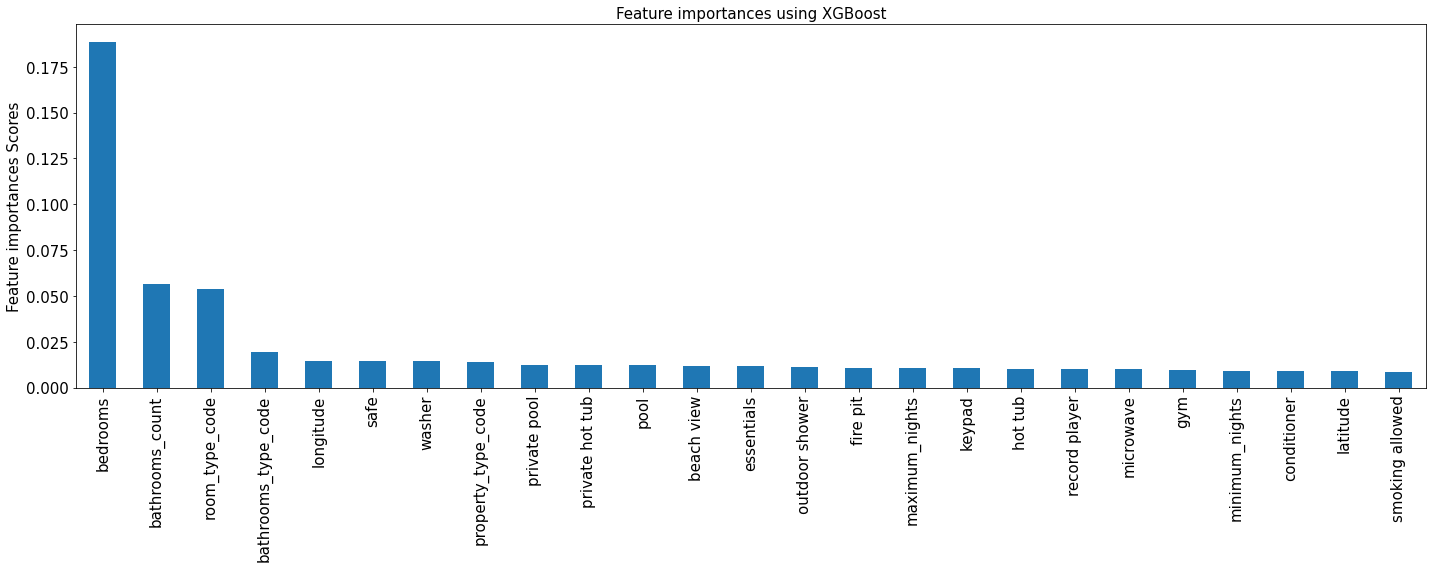



Cluster 2: Chart for feature importances


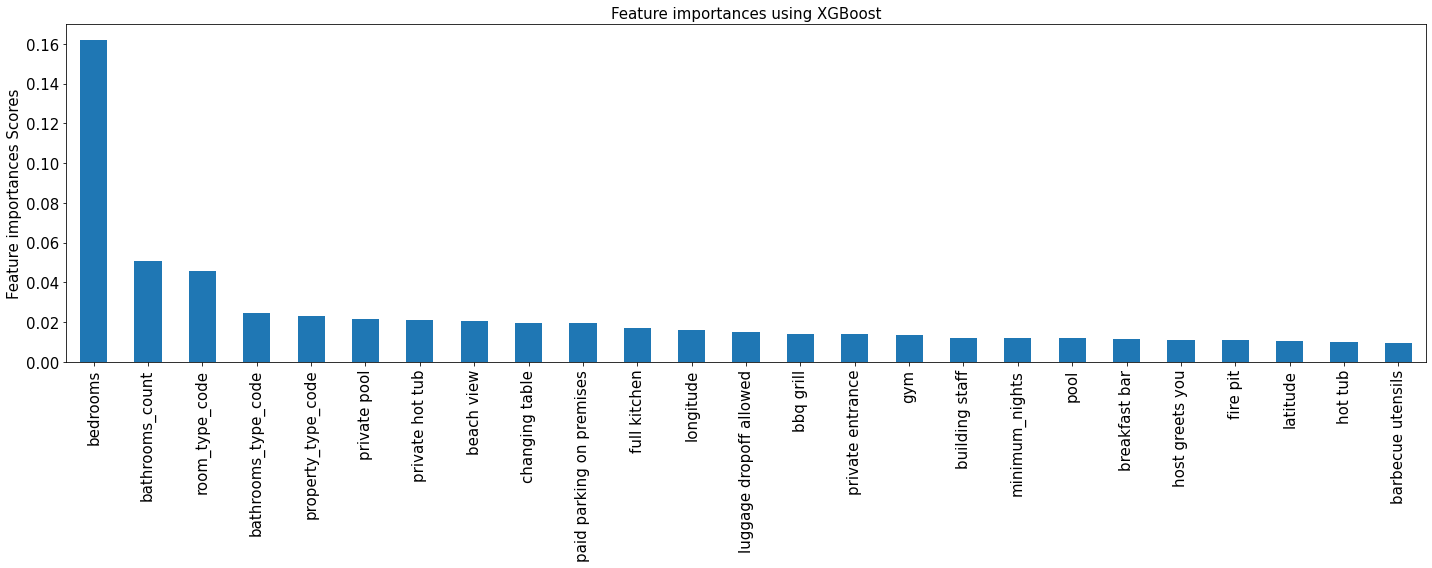

In [ ]:
importance_count = 25

xgb_cluster_top_feature_importance = []

for i in range(len(valid_cluster_list)):
    # Extract the data for each cluster
    cluster_number = valid_cluster_list[i]
    best_model = xgb_cluster_best_model_list[i]
    importance_xgbregressor = best_model.feature_importances_
    
    xgbregressor_importances = pd.Series(importance_xgbregressor, index=model_data.columns[1:])
    xgbregressor_importances_top = xgbregressor_importances.sort_values(ascending=False).iloc[:importance_count]
    xgb_cluster_top_feature_importance.append(xgbregressor_importances_top)
    print(f'Cluster {cluster_number}: Chart for feature importances')
    
    fig, ax = plt.subplots(figsize=(20,8))
    xgbregressor_importances_top.plot.bar(xgbregressor_importances_top, ax=ax)
    ax.set_title("Feature importances using XGBoost",fontsize=15)
    ax.set_ylabel("Feature importances Scores",fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    fig.tight_layout()
    plt.show()
    print('\n')

### Top 25 Amenities by Count

In [ ]:
top_count = 20
top_amenities_count = pd.DataFrame(amenities_feature_count_df.sum(axis = 0).sort_values(ascending=False).iloc[:top_count],columns = ['Count'])
top_amenities_count

,Count
long term stays allowed,18718
smoke alarm,17377
kitchen,16712
carbon monoxide alarm,15568
essentials,14882
shampoo,13729
iron,13687
hangers,13597
hot water,13324
dishes and silverware,12714


### Top Features by Importances

In [ ]:
for i in range(len(valid_cluster_list)):
    # Extract the data for each cluster
    cluster_number = valid_cluster_list[i]

    comparison_df = pd.concat([rfr_cluster_top_feature_importance[i].reset_index(), xgb_cluster_top_feature_importance[i].reset_index()], axis=1)
    comparison_df.columns = ['RFR index','RFR score','XGB index','XGB score']
    print(f'Top feature importance: cluster {cluster_number}')
    display(comparison_df)

Top feature importance: cluster 0


,RFR index,RFR score,XGB index,XGB score
0,bedrooms,0.404544,bedrooms,0.188693
1,bathrooms_count,0.150433,bathrooms_count,0.056575
2,longitude,0.096238,room_type_code,0.053756
3,latitude,0.056283,bathrooms_type_code,0.019386
4,amenities_count,0.031372,longitude,0.014743
5,property_type_code,0.028378,safe,0.014478
6,neighbourhood_cleansed_code,0.024323,washer,0.014417
7,minimum_nights,0.020450,property_type_code,0.013885
8,room_type_code,0.015714,private pool,0.012406
9,beds,0.010216,private hot tub,0.012367


Top feature importance: cluster 2


,RFR index,RFR score,XGB index,XGB score
0,bedrooms,0.374010,bedrooms,0.161638
1,bathrooms_count,0.139265,bathrooms_count,0.050705
2,longitude,0.103627,room_type_code,0.045938
3,latitude,0.061674,bathrooms_type_code,0.024553
4,property_type_code,0.051380,property_type_code,0.022866
5,amenities_count,0.030334,private pool,0.021734
6,neighbourhood_cleansed_code,0.020086,private hot tub,0.021133
7,minimum_nights,0.018683,beach view,0.020784
8,room_type_code,0.017126,changing table,0.019823
9,maximum_nights,0.016438,paid parking on premises,0.019789


In [ ]:
top_overlapping_amenities = list(set(comparison_df['RFR index']).intersection(set(comparison_df['XGB index'])))

print(len(top_overlapping_amenities))
top_overlapping_amenities

12


['latitude',
 'longitude',
 'pool',
 'bathrooms_type_code',
 'paid parking on premises',
 'minimum_nights',
 'bedrooms',
 'gym',
 'bathrooms_count',
 'room_type_code',
 'bbq grill',
 'property_type_code']

# Average the predictions of both models

In [ ]:
display(forest_sample_comparison_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
predict,938.0,137.0,78.0,137.0,326.0,153.0,169.0,399.0,84.0,96.0,164.0,212.0,498.0,225.0,49.0,82.0,72.0,403.0,160.0,224.0
test,1039.0,79.0,50.0,110.0,550.0,123.0,139.0,490.0,100.0,89.0,166.0,163.0,464.0,388.0,50.0,75.0,75.0,363.0,204.0,107.0


In [ ]:
display(xgboost_sample_comparison_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
predict,975.0,126.0,51.0,118.0,309.0,220.0,117.0,375.0,95.0,87.0,133.0,227.0,500.0,248.0,40.0,73.0,61.0,432.0,162.0,229.0
test,1039.0,79.0,50.0,110.0,550.0,123.0,139.0,490.0,100.0,89.0,166.0,163.0,464.0,388.0,50.0,75.0,75.0,363.0,204.0,107.0


In [ ]:
final_y_predict = (xgb_y_predict + rfr_y_predict)/2
display(pd.DataFrame({'predict':final_y_predict[:20],'test':list(y_test[:20])}).T)
r2_score(y_test,final_y_predict, multioutput='variance_weighted')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
predict,956.5,131.5,64.5,127.5,317.5,186.5,143.0,387.0,89.5,91.5,148.5,219.5,499.0,236.5,44.5,77.5,66.5,417.5,161.0,226.5
test,1039.0,79.0,50.0,110.0,550.0,123.0,139.0,490.0,100.0,89.0,166.0,163.0,464.0,388.0,50.0,75.0,75.0,363.0,204.0,107.0


0.6931156763734818

## Closest host around your property